In [1]:
import xarray as xr
import os
import pandas as pd

ModuleNotFoundError: No module named 'xarray'

In [2]:
# get paths. Note the 1.87GB netcdf gebco dataset has been downloaded separate, see README for source info
path_root = os.getcwd()
# path_in = os.path.join(os.path.dirname(path_root),'_raw')
path_out = os.path.join(path_root,'subset')

In [ ]:
path_in = '/home/sam/Dropbox/data/reference/gebco/raw'

In [3]:
# create an xarray data array from the raw netcdf file
da = xr.open_dataarray(os.path.join(path_in,'GEBCO_2014_2D.nc'))

In [4]:
# print data array metadata for the netcdf
# there are a bunch of properties of the dataarray, like "dims","coords","attrs" amongst others
da

<xarray.DataArray 'elevation' (lat: 21600, lon: 43200)>
[933120000 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.99 -89.98 -89.97 -89.96 -89.95 -89.95 ...
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 -180.0 -180.0 -179.9 ...
Attributes:
    standard_name:       height_above_reference_ellipsoid
    long_name:           Elevation relative to sea level
    units:               m
    sdn_parameter_urn:   SDN:P01::BATHHGHT
    sdn_parameter_name:  Sea floor height (above mean sea level) {bathymetric...
    sdn_uom_urn:         SDN:P06:ULAA
    sdn_uom_name:        Metres

In [5]:
# print dimension names of the data array
da.dims

('lat', 'lon')

In [6]:
# print the attributes of the dataset
da.attrs

OrderedDict([('standard_name', 'height_above_reference_ellipsoid'),
             ('long_name', 'Elevation relative to sea level'),
             ('units', 'm'),
             ('sdn_parameter_urn', 'SDN:P01::BATHHGHT'),
             ('sdn_parameter_name',
              'Sea floor height (above mean sea level) {bathymetric height}'),
             ('sdn_uom_urn', 'SDN:P06:ULAA'),
             ('sdn_uom_name', 'Metres')])

In [7]:
# create a list of the coordinates of a given dimension of the data array as a python list
# limiting to the first 3 items
# Some notes
#  "xarraydataarry.values > ".values" converts to a numpy array
#  ".tolist()" is a method to convert the numpy array to a python list
#  list[0:3] or written as "list[:3]" displays list item number "0", "1", "2", "3".
da.coords['lat'].values.tolist()[0:4]

[-89.99583333333332, -89.9875, -89.97916666666666, -89.97083333333333]

In [8]:
# spatially subset the big grid to a smaller grid for Europe (easier to handle)
subset = da.where((-10 < da.lon) & (da.lon < 10) & (50 < da.lat) & (da.lat < 70), drop=True)

In [9]:
# since the data is an array, also refered to as a matrix, you can 
# do stats on the matrix, like a min and max
print('min = ' + str(subset.min().item(0)) + '\nmax = ' + str(subset.max().item(0)))

min = -3948.0
max = 2292.0


In [10]:
subset.plot();
# the xarray .plot() method calls matplotlib under the hood.
# if the data is 2D or 3D grid, plot() defaults to 'pcolormesh' the type 
# if the data is a 1D timeseries, plot() defaults to a 'line' plot type

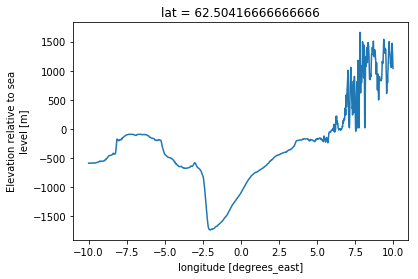

In [11]:
# plot a proflie across the grid at a given latitude
subset.sel(lat=62.5,method='nearest').plot();

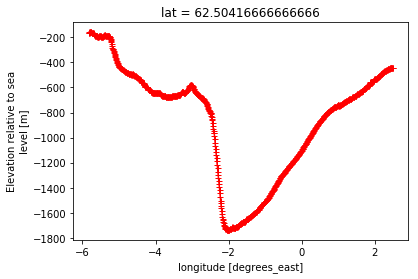

In [12]:
# you can do lots here, slice the array i.e. just present array items with an index between 500 and 800
# also, you can pass in matplotlib key word arguements (kwargs) setting line color and marker type (amongst others)
subset.sel(lat=62.5,method='nearest')[500:1500].plot.line(color='red', marker='+');

In [13]:
# export the DEM profile to a csv making sure the columns are order by lon,lat,depth ie x,y,z

# create a pandas dataframe for a given index value the latitude nearest 65 degrees)
df = subset.sel(lat=65,method='nearest').to_dataframe(name='z')

# we don't need an index for x,y,z data
df = df.reset_index()

# renmae the column headers in the pandas dataframe
df.columns = ['x','y','z']

# print the top 5 rows
df.head(5)

,x,y,z
0,-9.995833,64.995833,-734.0
1,-9.987500,64.995833,-738.0
2,-9.979167,64.995833,-741.0
3,-9.970833,64.995833,-745.0
4,-9.962500,64.995833,-748.0


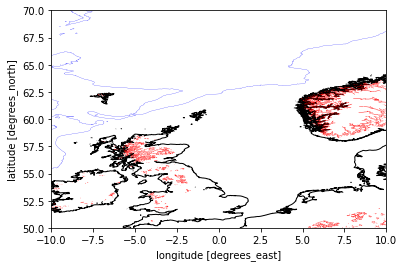

In [14]:
# get funky with key word arguements (kwargs), e.g. with specifying lists of arguements
# note the number of items needs to stay the same between arguements.
# there's plenty of functionality, e.g. list colours accepting different types of input
# So here, three elevation contours are specifed, with different colours applied, and different line weights
subset.plot.contour(colors=['blue','#000000','r'],levels=[-1000,0,500],linewidths=[0.2,1,0.2]);

In [15]:
# up to now we've been using the plot method of the xarray
# the package "cartopy" allows for data to be reprojected and drawn with separate geospatial
# vector data, like coastlines.
# Load the packages. "pyplot" is a significant module of matplotlib and widely used.

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

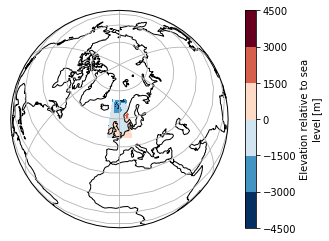

In [16]:
# matplotlib work by initialising a matplotlib figure 
# then you define additional attributes to the figure, like adding data, labels, colors, whatever

# initialize a matplotlib figure
fig = plt.figure()

# this creats a 'geoaxes' object and sets the projection to a cool looking orthographic projection
ax = plt.axes(projection=ccrs.Orthographic(-0, 60))

# this line calls the plot method of the dataarray and passes the 'GeoAxesSubplot' object
my_plot = subset.plot.contourf(ax=ax, transform=ccrs.PlateCarree());

# set the extent of the plot to a global view
ax.set_global();

# add gridlines to the plot
ax.gridlines();

# add vector coastlines (these download from "natural-earth")
ax.coastlines();

# close the plot
plt.show()

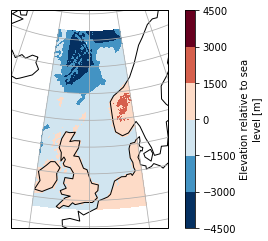

In [17]:
# zoom to a fixed extent 

# initialize a matplotlib figure
fig = plt.figure()

# this creats a 'geoaxes' object and sets the projection to a cool looking orthographic projection
ax = plt.axes(projection=ccrs.Orthographic(-0, 60))

# this line calls the plot method of the dataarray and passes the 'GeoAxesSubplot' object
my_plot = subset.plot.contourf(ax=ax, transform=ccrs.PlateCarree());

# set the extent of the plot to a global view
ax.set_extent([-13, 13, 47, 72]);

# add gridlines to the plot
ax.gridlines();

# add vector coastlines (these download from "natural-earth")
ax.coastlines();

# close the plot
plt.show()

In [18]:
# use type to identify the data type of an python object
print('"ax" type      = ' + str(type(ax)) + '\n' + '"my_plot" type = ' + str(type(my_plot)))

"ax" type      = <class 'cartopy.mpl.geoaxes.GeoAxesSubplot'>
"my_plot" type = <class 'matplotlib.contour.QuadContourSet'>


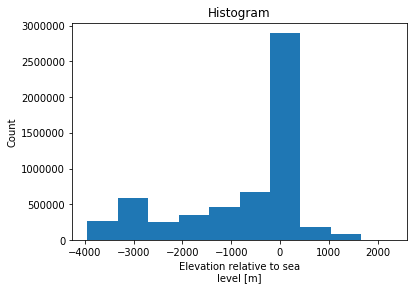

In [19]:
# plot a histogram of data values in the data array.
# Notes
#  * Use a semi-colon to prevent printing the array data out
#  * Instantiating the plot method will initalise the figure automatically
subset.plot.hist();

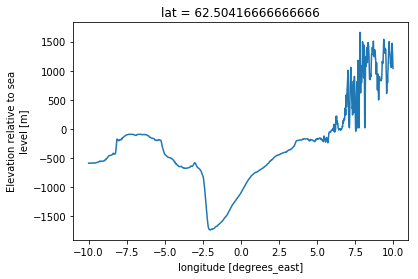

In [20]:
subset.sel(lat=62.5,method='nearest').plot();

In [21]:
import seaborn as sns
# Seaborn is a library that makes matplotlib plots...well..nicer.
# Once seaborn is imported, it will override the matplolib defaults

In [22]:
# apply global "styles" to subsequent plots using "set"
sns.set_style('darkgrid'); # Set the aesthetic style of the plots.
sns.despine() # Remove the top and right spines (borders) from plot.

<Figure size 432x288 with 0 Axes>

In [23]:
# return the default seaborn styles
sns.axes_style()

{'axes.facecolor': '#EAEAF2',
 'axes.edgecolor': 'white',
 'axes.grid': True,
 'axes.axisbelow': True,
 'axes.linewidth': 0.0,
 'axes.labelcolor': '.15',
 'figure.facecolor': 'white',
 'grid.color': 'white',
 'grid.linestyle': '-',
 'text.color': '.15',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'xtick.major.size': 0.0,
 'ytick.major.size': 0.0,
 'xtick.minor.size': 0.0,
 'ytick.minor.size': 0.0,
 'legend.frameon': False,
 'legend.numpoints': 1,
 'legend.scatterpoints': 1,
 'lines.solid_capstyle': 'round',
 'image.cmap': 'rocket',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif']}

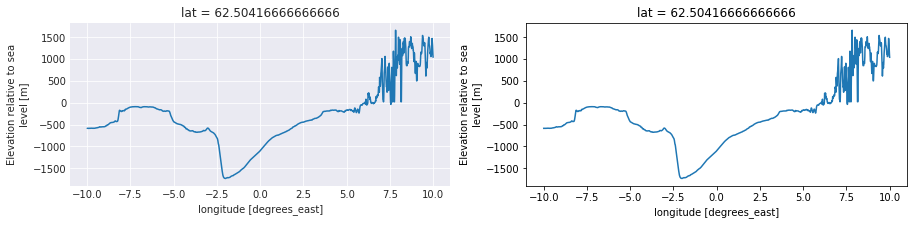

In [93]:
# compare the seaborn figure with the matplotlib original

# reset seaborn configuration back to matplotlib
sns.reset_orig()

# create a figure object and sea a landscape aspect ratio.
f = plt.figure(figsize=(15, 3))

# create a temporary instance of a a seaborn plot using "with"
with sns.axes_style("darkgrid"):
    ax = f.add_subplot(1, 2, 1) # this adds a "subplot" (no. of rows, no of cols, index number)
    subset.sel(lat=62.5,method='nearest').plot();

# create a standard matplotlib line plot
ax = f.add_subplot(1, 2, 2) # this adds a "subplot" (no. of rows, no of cols, index number)
subset.sel(lat=62.5,method='nearest').plot();

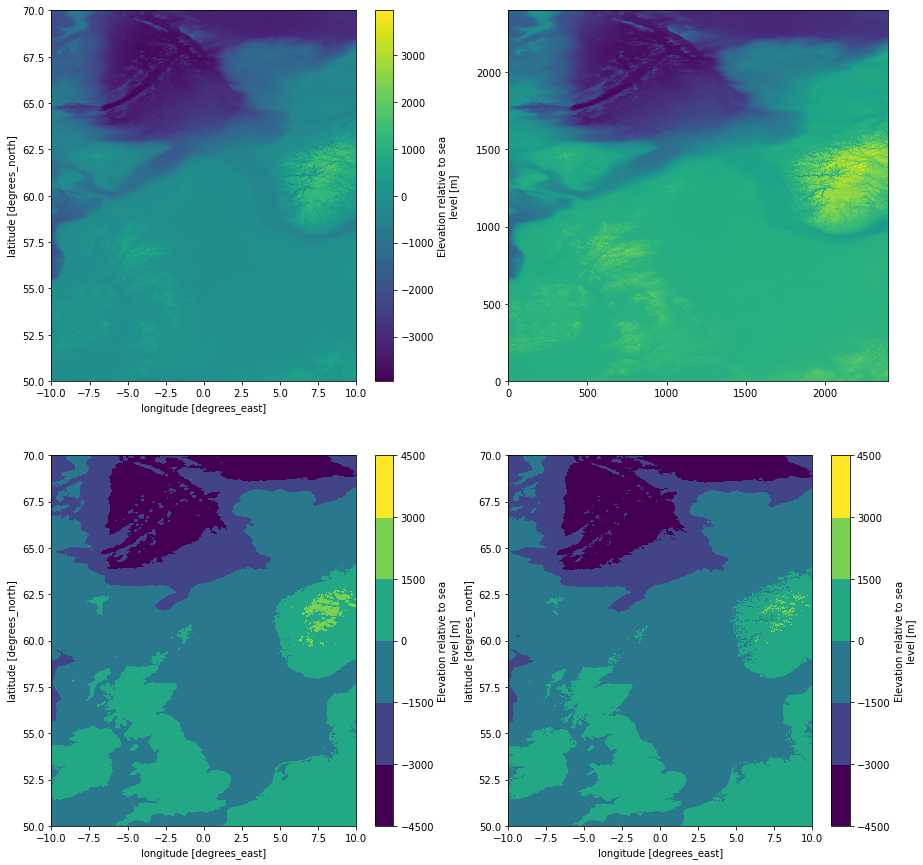

In [33]:
# create a figure object
f = plt.figure(figsize=(15, 15))

# plot 1
# plot with the xarray defaults
ax1 = f.add_subplot(2, 2, 1) # this adds a "subplot" (no. of rows, no of cols, index number)
subset.plot(cmap='viridis');

# plot 2
# call the matplotlib pcolormesh plot type
# notice there are minimal defaults, no axis labels, no colorbar.
ax2 = f.add_subplot(2, 2, 2)
plt.pcolormesh(subset)

# plot 3
# plot with xarray filled contour plot
ax3 = f.add_subplot(2, 2, 3)
subset.plot.contourf(cmap='viridis')

# plot 4
# plot with xarray default but specify a number of levels. 
ax4 = f.add_subplot(2, 2, 4)
subset.plot(cmap='viridis',levels=7);

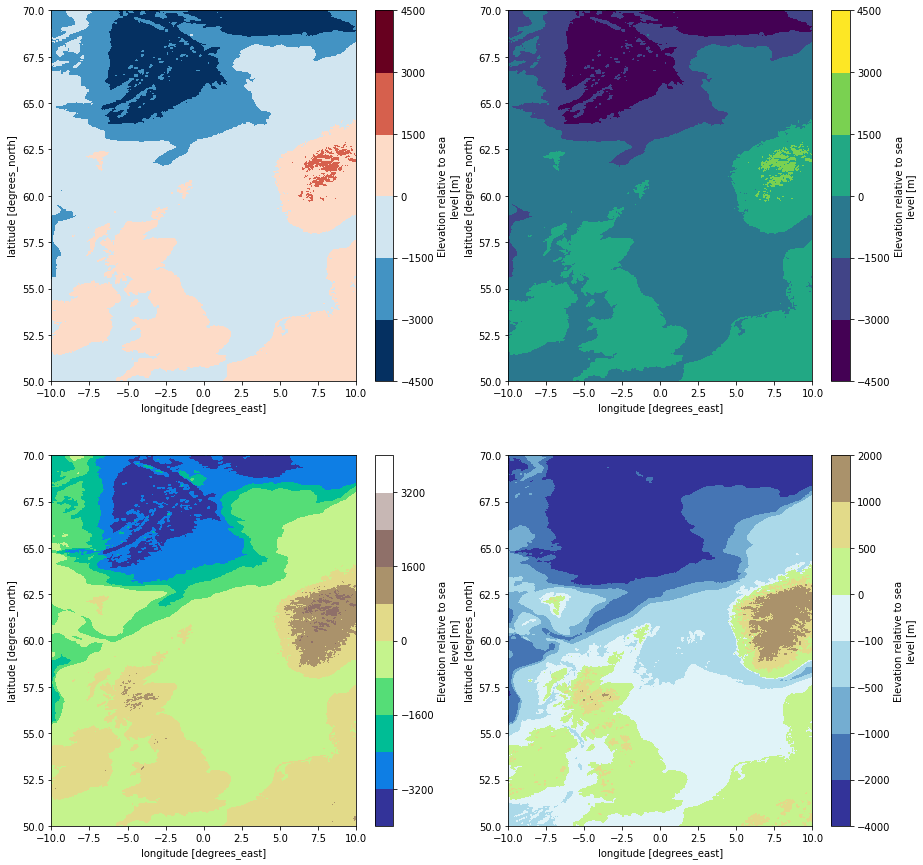

In [61]:
# create a figure object
f = plt.figure(figsize=(15, 15))

# plot 1
# plot with the xarray defaults
ax1 = f.add_subplot(2, 2, 1) # this adds a "subplot" (no. of rows, no of cols, index number)
subset.plot.contourf()

# plot 2
# call the matplotlib pcolormesh plot type
# notice there are minimal defaults, no axis labels, no colorbar.
ax2 = f.add_subplot(2, 2, 2)
subset.plot.contourf(cmap='viridis')

# plot 3
# plot with xarray filled contour plot
ax3 = f.add_subplot(2, 2, 3)
subset.plot.contourf(cmap='terrain',levels=12)

# plot 4
# plot with xarray default but specify a number of levels. 
ax4 = f.add_subplot(2, 2, 4)
subset.plot.contourf(colors=['#333399','#4575b4','#74add1','#abd9e9','#e0f3f8','#c5f38d','#e2da89','#aa926b','#ffffff'],
                     levels=[-4000,-2000,-1000,-500,-100,0,500,1000,2000],
                     extend='neither'
                    )